In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import scipy as sp
from scipy import cluster as scl
from scipy import io as sio
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec as gs
from nilearn import plotting as nlp
import pandas as pd
import itertools

In [3]:
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
sim_p = os.path.join(path_root,'subtype_3_spm_EMOTION_18-Oct-2017/networks/contrast_fear_vs_neut/subtype_contrast_fear_vs_neut.mat')
stack_p = os.path.join(path_root,'subtype_5_spm_LANGUAGE_18-Oct-2017/networks/story/stack_story.mat')

In [4]:
%load_ext oct2py.ipython

In [5]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [6]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [7]:
mat_subt = sio.loadmat(sim_p)

In [8]:
mat_stack =  sio.loadmat(stack_p)

In [9]:
# extract partitioning of clrusters from mat file 
%octave_push sim_p
%octave mat_load = load(sim_p);
%octave_pull mat_load
stack_subj_part = np.concatenate((np.vstack(mat_load['list_subject']),mat_load['part'].astype('int')),axis=1)

In [10]:
# extract partitioning of clrusters from mat file 
%octave_push stack_p
%octave stack_load = load(stack_p);
%octave_pull stack_load
#stack_subj_part = np.concatenate((np.vstack(mat_load['list_subject']),mat_load['part'].astype('int')),axis=1)

In [11]:
mat_subt.keys()

dict_keys(['__version__', 'sub', '__globals__', 'subj_order', 'sim_matrix', '__header__', 'hier', 'list_subject', 'part'])

In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

In [13]:
coll,a=_cmap_from_image_path('/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/Figures/subtypes/Paper_association_heritability/color_palette_raich4.png')
#invert color map
coll_r = matplotlib.colors.ListedColormap(coll[::-1])

In [14]:
stack_load['stack'].min()

-0.043519466204952985

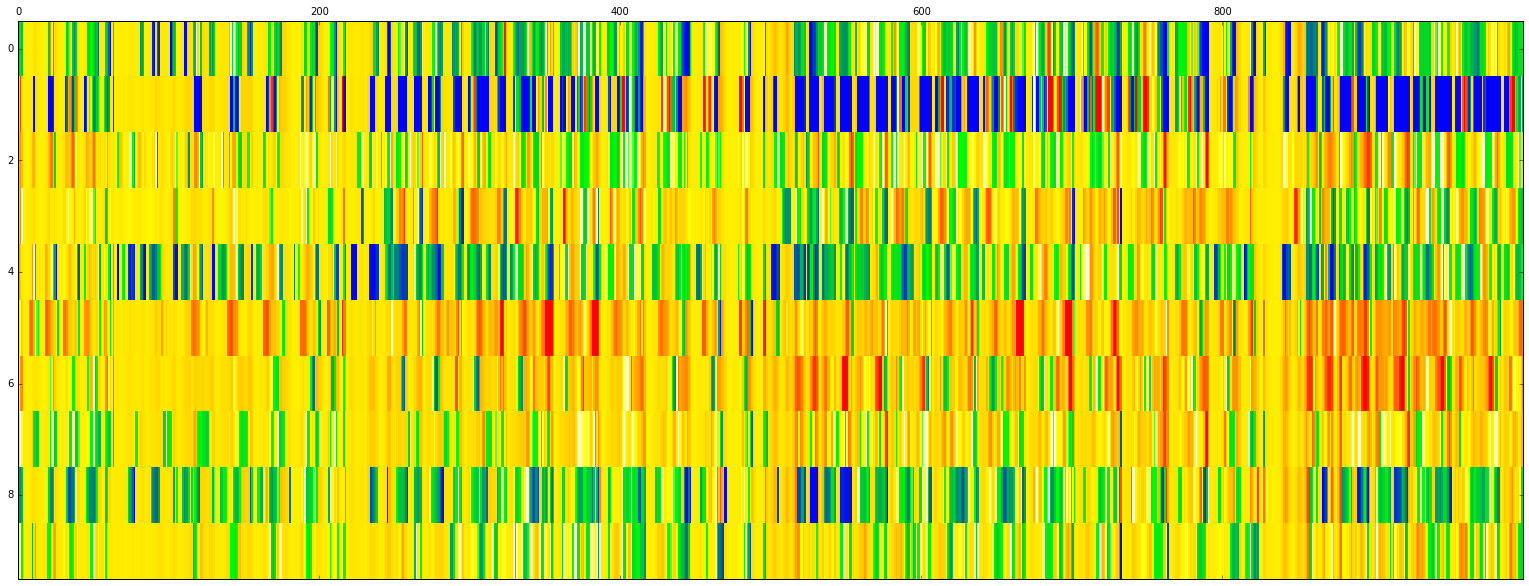

In [15]:
# plot all stack
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(stack_load['stack'][:10,:1000],aspect='auto',cmap =a,vmin=-0.0026, vmax=0.0018)
f.savefig(os.path.join(path_root,'Figures/subtypes/Paper_association_heritability/all_stack.svg'))

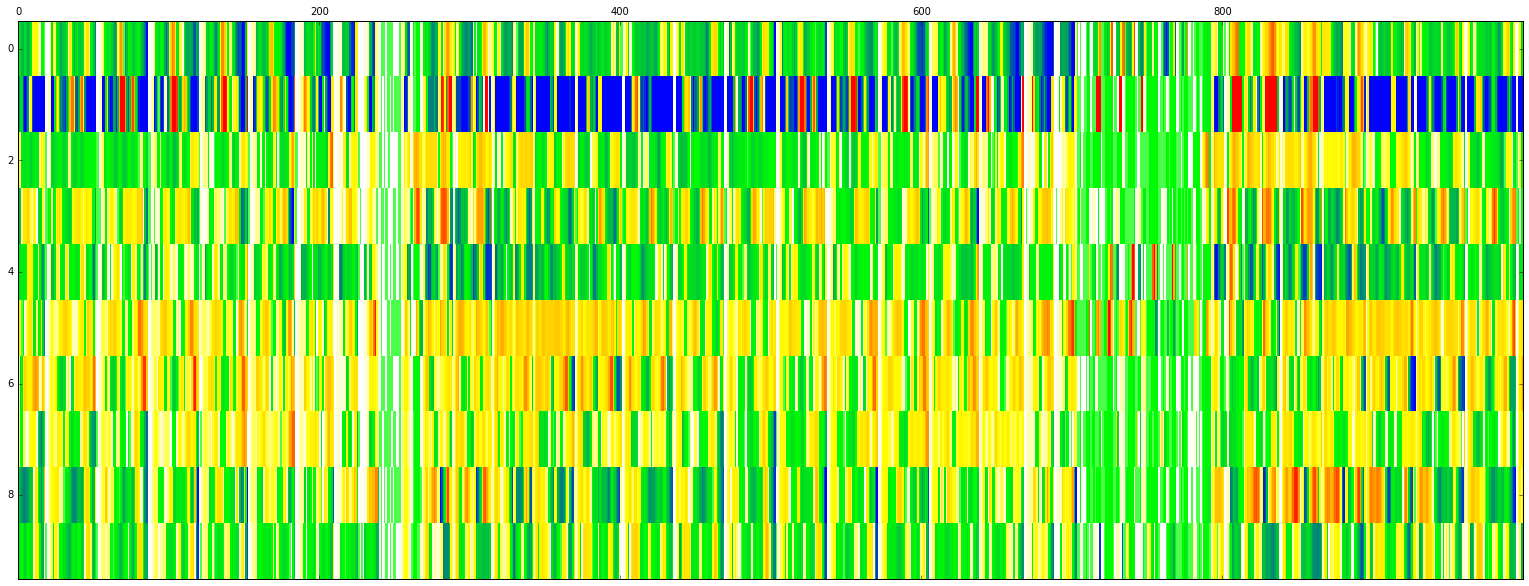

In [16]:
# plot all stack
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,10))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(stack_load['stack'][:10,1000:2000],aspect='auto',cmap =a,vmin=-0.003, vmax=0.003)
f.savefig(os.path.join(path_root,'Figures/subtypes/Paper_association_heritability/all_stack_resid.svg'))

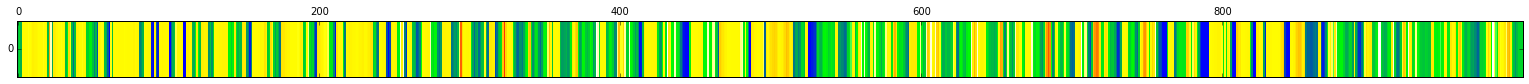

In [17]:
# plot one subject stack
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(30,1))
ax = f.add_subplot(gsp[:,:18])
#axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(stack_load['stack'][:1,:1000],aspect='auto',cmap =a,vmin=-0.0025, vmax=0.002)
f.savefig(os.path.join(path_root,'Figures/subtypes/Paper_association_heritability/1subj_stack.svg'))

In [18]:
stack_load['stack'].min()

-0.043519466204952985

In [30]:
sim

array([[ 1.        , -0.12397413,  0.08671675, ..., -0.0979688 ,
         0.11500904, -0.09576981],
       [-0.12397413,  1.        , -0.3085928 , ...,  0.05668181,
        -0.18297784,  0.03895768],
       [ 0.08671675, -0.3085928 ,  1.        , ..., -0.1671089 ,
         0.18773558, -0.08996773],
       ..., 
       [-0.0979688 ,  0.05668181, -0.1671089 , ...,  1.        ,
        -0.02662651,  0.09668784],
       [ 0.11500904, -0.18297784,  0.18773558, ..., -0.02662651,
         1.        , -0.0701237 ],
       [-0.09576981,  0.03895768, -0.08996773, ...,  0.09668784,
        -0.0701237 ,  1.        ]])

In [57]:
np.triu(sim, 1).astype(bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ..., 
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [51]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])

a[np.triu_indices(3,1)]

array([2, 3, 6])

In [52]:
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [50]:
np.triu_indices(4, 1)

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

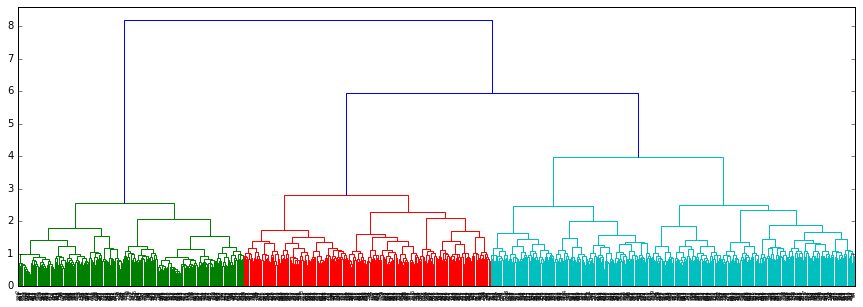

In [22]:
sim = mat_subt['sim_matrix']
mask = np.triu(sim, 1).astype(bool)
svec = sim[mask]
dist = 1 - svec
n_sbt = 3
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)


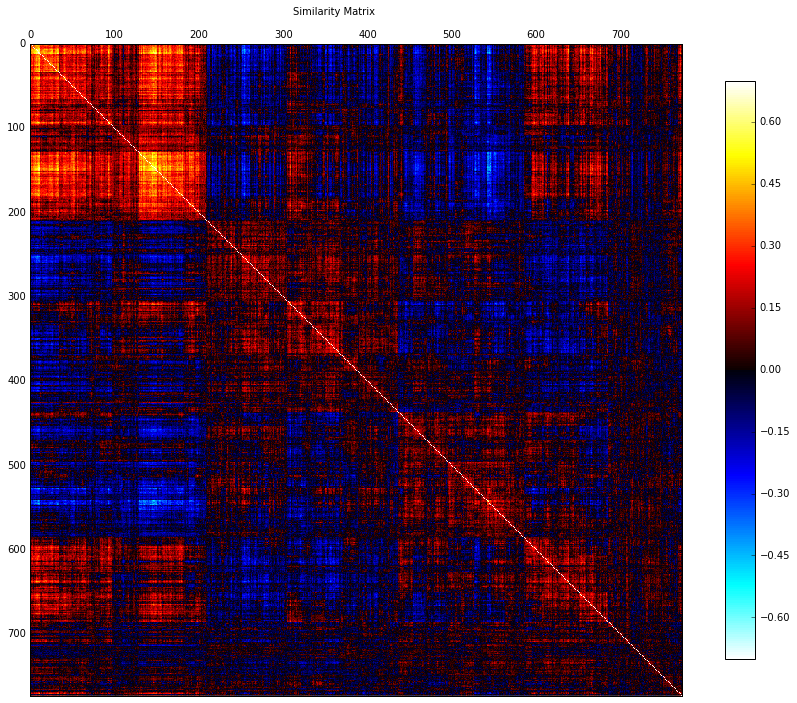

In [43]:
# Plot the distance matrix again, but now ordered by hierarchy
#label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[:,:18])
axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(sim[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none',vmin=-0.7, vmax=0.7)
#tmp = ax.set_yticks(range(len(use_columns)))
#tmp = ax.set_yticklabels(label_ord)
#tmp = ax.set_xticks(range(len(use_columns)))
#tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('Similarity Matrix',y=0.9,x=0.45)

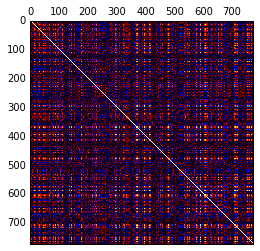

In [44]:
plt.matshow(sim, vmin=-0.6, vmax=0.6, cmap=nlp.cm.cold_hot)

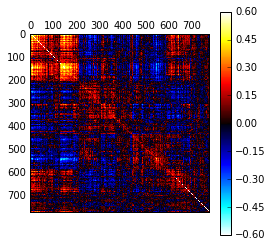

In [45]:
plt.matshow(sim[:, order][order, :], vmin=-0.6, vmax=0.6, cmap=nlp.cm.cold_hot)
plt.colorbar()

In [46]:
# Order clustered correlation matrix
t_clust = sim[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

# Set color code
s2_colors = ["#f6afed",
             "#514c82"]

s3_colors = ["#f6afed",
             "#ec8b00",
             "#514c82"]

s4_colors = ["#f6afed",
             "#ec8b00",
             "#514c82",
             "#beb146"]
s5_colors = ["#cb5362",
            "#6ea84e",
            "#9d6cc1",
            "#bb873c",
            "#3fadaf"]

s6_colors = ["#cc5452",
            "#50ac72",
            "#c45ca2",
            "#929d3d",
            "#7879cd",
            "#c8803e"]

s7_colors = ["#bf61bb",
            "#60a75b",
            "#746cc9",
            "#b1963f",
            "#5aa4d1",
            "#cb623f",
            "#c8567a"]

s8_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e"]

s9_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e",
             "#717833"]


s10_colors =["#8562cc",
            "#60b14d",
            "#c361aa",
            "#bab241",
            "#688bcd",
            "#cd5136",
            "#4bb092",
            "#ca586f",
            "#717e37",
            "#c58443"]


lin2 = LinearSegmentedColormap.from_list(name='s2',
                                         colors = s2_colors,
                                         N=n_sbt)
lin3 = LinearSegmentedColormap.from_list(name='s3',
                                         colors = s3_colors,
                                         N=n_sbt)
lin4 = LinearSegmentedColormap.from_list(name='s4',
                                         colors = s4_colors,
                                         N=n_sbt)
lin5 = LinearSegmentedColormap.from_list(name='s5',
                                         colors = s5_colors,
                                         N=n_sbt)
lin6 = LinearSegmentedColormap.from_list(name='s6',
                                         colors = s6_colors,
                                         N=n_sbt)
lin7 = LinearSegmentedColormap.from_list(name='s7',
                                         colors = s7_colors,
                                         N=n_sbt)
lin8 = LinearSegmentedColormap.from_list(name='s8',
                                         colors = s8_colors,
                                         N=n_sbt)
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                         colors = s9_colors,
                                         N=n_sbt)
lin10 = LinearSegmentedColormap.from_list(name='s10',
                                          colors = s10_colors,
                                          N=n_sbt)

In [47]:
# make strtucture to store different colors parameters
struc = {}
struc["2"]={}
struc["2"]["lin"] = lin2
struc["2"]["s_colors"] = s2_colors
struc["3"]={}
struc["3"]["lin"] = lin3
struc["3"]["s_colors"] = s3_colors
struc["4"]={}
struc["4"]["lin"] = lin4
struc["4"]["s_colors"] = s4_colors
struc["5"]={}
struc["5"]["lin"] = lin5
struc["5"]["s_colors"] = s5_colors
struc["6"]={}
struc["6"]["lin"] = lin6
struc["6"]["s_colors"] = s6_colors
struc["7"]={}
struc["7"]["lin"] = lin7
struc["7"]["s_colors"] = s7_colors
struc["8"]={}
struc["8"]["lin"] = lin8
struc["8"]["s_colors"] = s8_colors
struc["9"]={}
struc["9"]["lin"] = lin9
struc["9"]["s_colors"] = s9_colors
struc["10"]={}
struc["10"]["lin"] = lin10
struc["10"]["s_colors"] = s10_colors

In [48]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(t_clust, cuts, 20,edge=True)

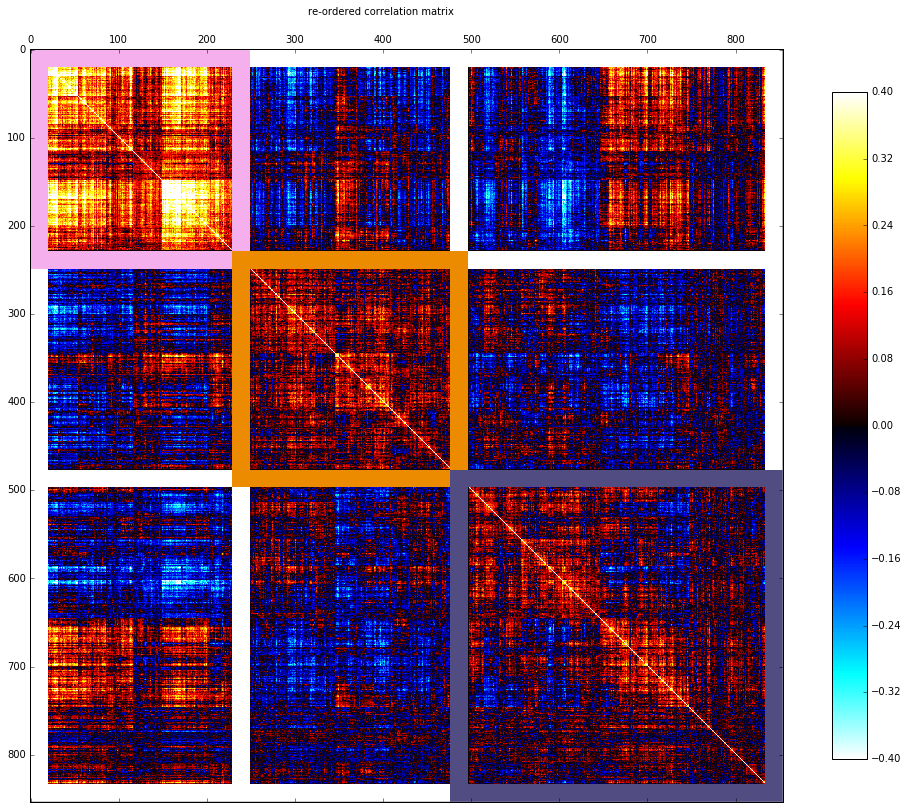

In [49]:
# Set figure
gsp = gs.GridSpec(10, 20)
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(gsp[:,:18])
axcl = f.add_subplot(gsp[1:9,19])
p = ax.matshow(mat, cmap=nlp.cm.cold_hot, vmin=-0.4, vmax=0.4)
tmp = ax.matshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.matshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.matshow(cmat, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
#tmp = ax.set_yticks(ind)
#tmp = ax.set_yticklabels(label_ord)
#tmp = ax.set_xticks(ind)
#tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
# for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
#     xtick.set_color(color)
#     ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered correlation matrix',y=0.9,x=0.45)
f.savefig(os.path.join(path_root,'Figures/subtypes/Paper_association_heritability/reordered_cor-mat.svg'))

In [29]:
b = sim[order[:350], :][:, order[:350]]

In [30]:
b.shape

(350, 350)

In [32]:
sim = b
mask = np.triu(sim, 1).astype(bool)
svec = sim[mask]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']

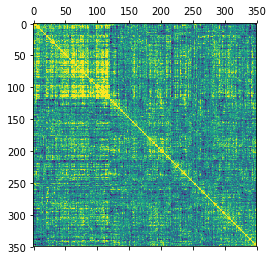

In [34]:
plt.matshow(b[order, :][:, order], vmin=-0.2, vmax=0.2)

In [22]:
np.max(sim[sim!=1])

0.86614530874461482